In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import requests
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


base_dir = Path("./food_classification")
train_dir = base_dir / "training"
val_dir = base_dir / "validation"
test_dir = base_dir / "evaluation"
for dir_path in [base_dir, train_dir, val_dir, test_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

device: cuda


In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

class_names = [
    'Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food',
    'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit'
]

In [4]:
def create_model(num_classes=11):
    """
    Создает модель VGG-11
    """
    model = models.vgg11(weights='IMAGENET1K_V1')
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    model = model.to(device)
    
    return model

model = create_model(len(class_names))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, scheduler=None):
    """
    Функция для обучения модели с валидацией
    """
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        
        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(epoch_val_loss)
        train_acc_history.append(epoch_train_acc)
        val_acc_history.append(epoch_val_acc)
        
        if scheduler:
            scheduler.step(epoch_val_loss)
        
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        print(f'  Best Val Acc: {best_val_acc:.4f}')
        print('-' * 50)
    
    model.load_state_dict(best_model_state)
    
    return model, {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }

def plot_training_history(history):
    """
    Визуализация процесса обучения
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Epoch 1/20:
  Train Loss: 1.1203, Train Acc: 0.7157
  Val Loss: 0.7040, Val Acc: 0.8132
  Best Val Acc: 0.8132
--------------------------------------------------
Epoch 2/20:
  Train Loss: 1.1743, Train Acc: 0.6890
  Val Loss: 0.7146, Val Acc: 0.8123
  Best Val Acc: 0.8132
--------------------------------------------------
Epoch 3/20:
  Train Loss: 1.1041, Train Acc: 0.6964
  Val Loss: 0.7588, Val Acc: 0.8106
  Best Val Acc: 0.8132
--------------------------------------------------
Epoch 4/20:
  Train Loss: 1.0781, Train Acc: 0.7115
  Val Loss: 0.6916, Val Acc: 0.8277
  Best Val Acc: 0.8277
--------------------------------------------------
Epoch 5/20:
  Train Loss: 1.0545, Train Acc: 0.7135
  Val Loss: 0.7682, Val Acc: 0.8193
  Best Val Acc: 0.8277
--------------------------------------------------
Epoch 6/20:
  Train Loss: 1.0088, Train Acc: 0.7215
  Val Loss: 0.6905, Val Acc: 0.8347
  Best Val Acc: 0.8347
--------------------------------------------------
Epoch 7/20:
  Train Loss: 0.

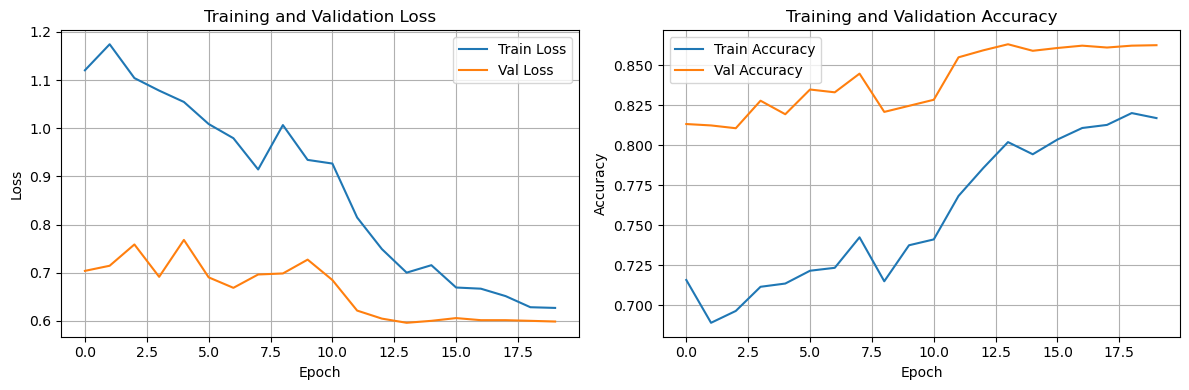

In [12]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print("=" * 60)

for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

model, history_stage1 = train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, 
    num_epochs=20, scheduler=scheduler
)

plot_training_history(history_stage1)

50


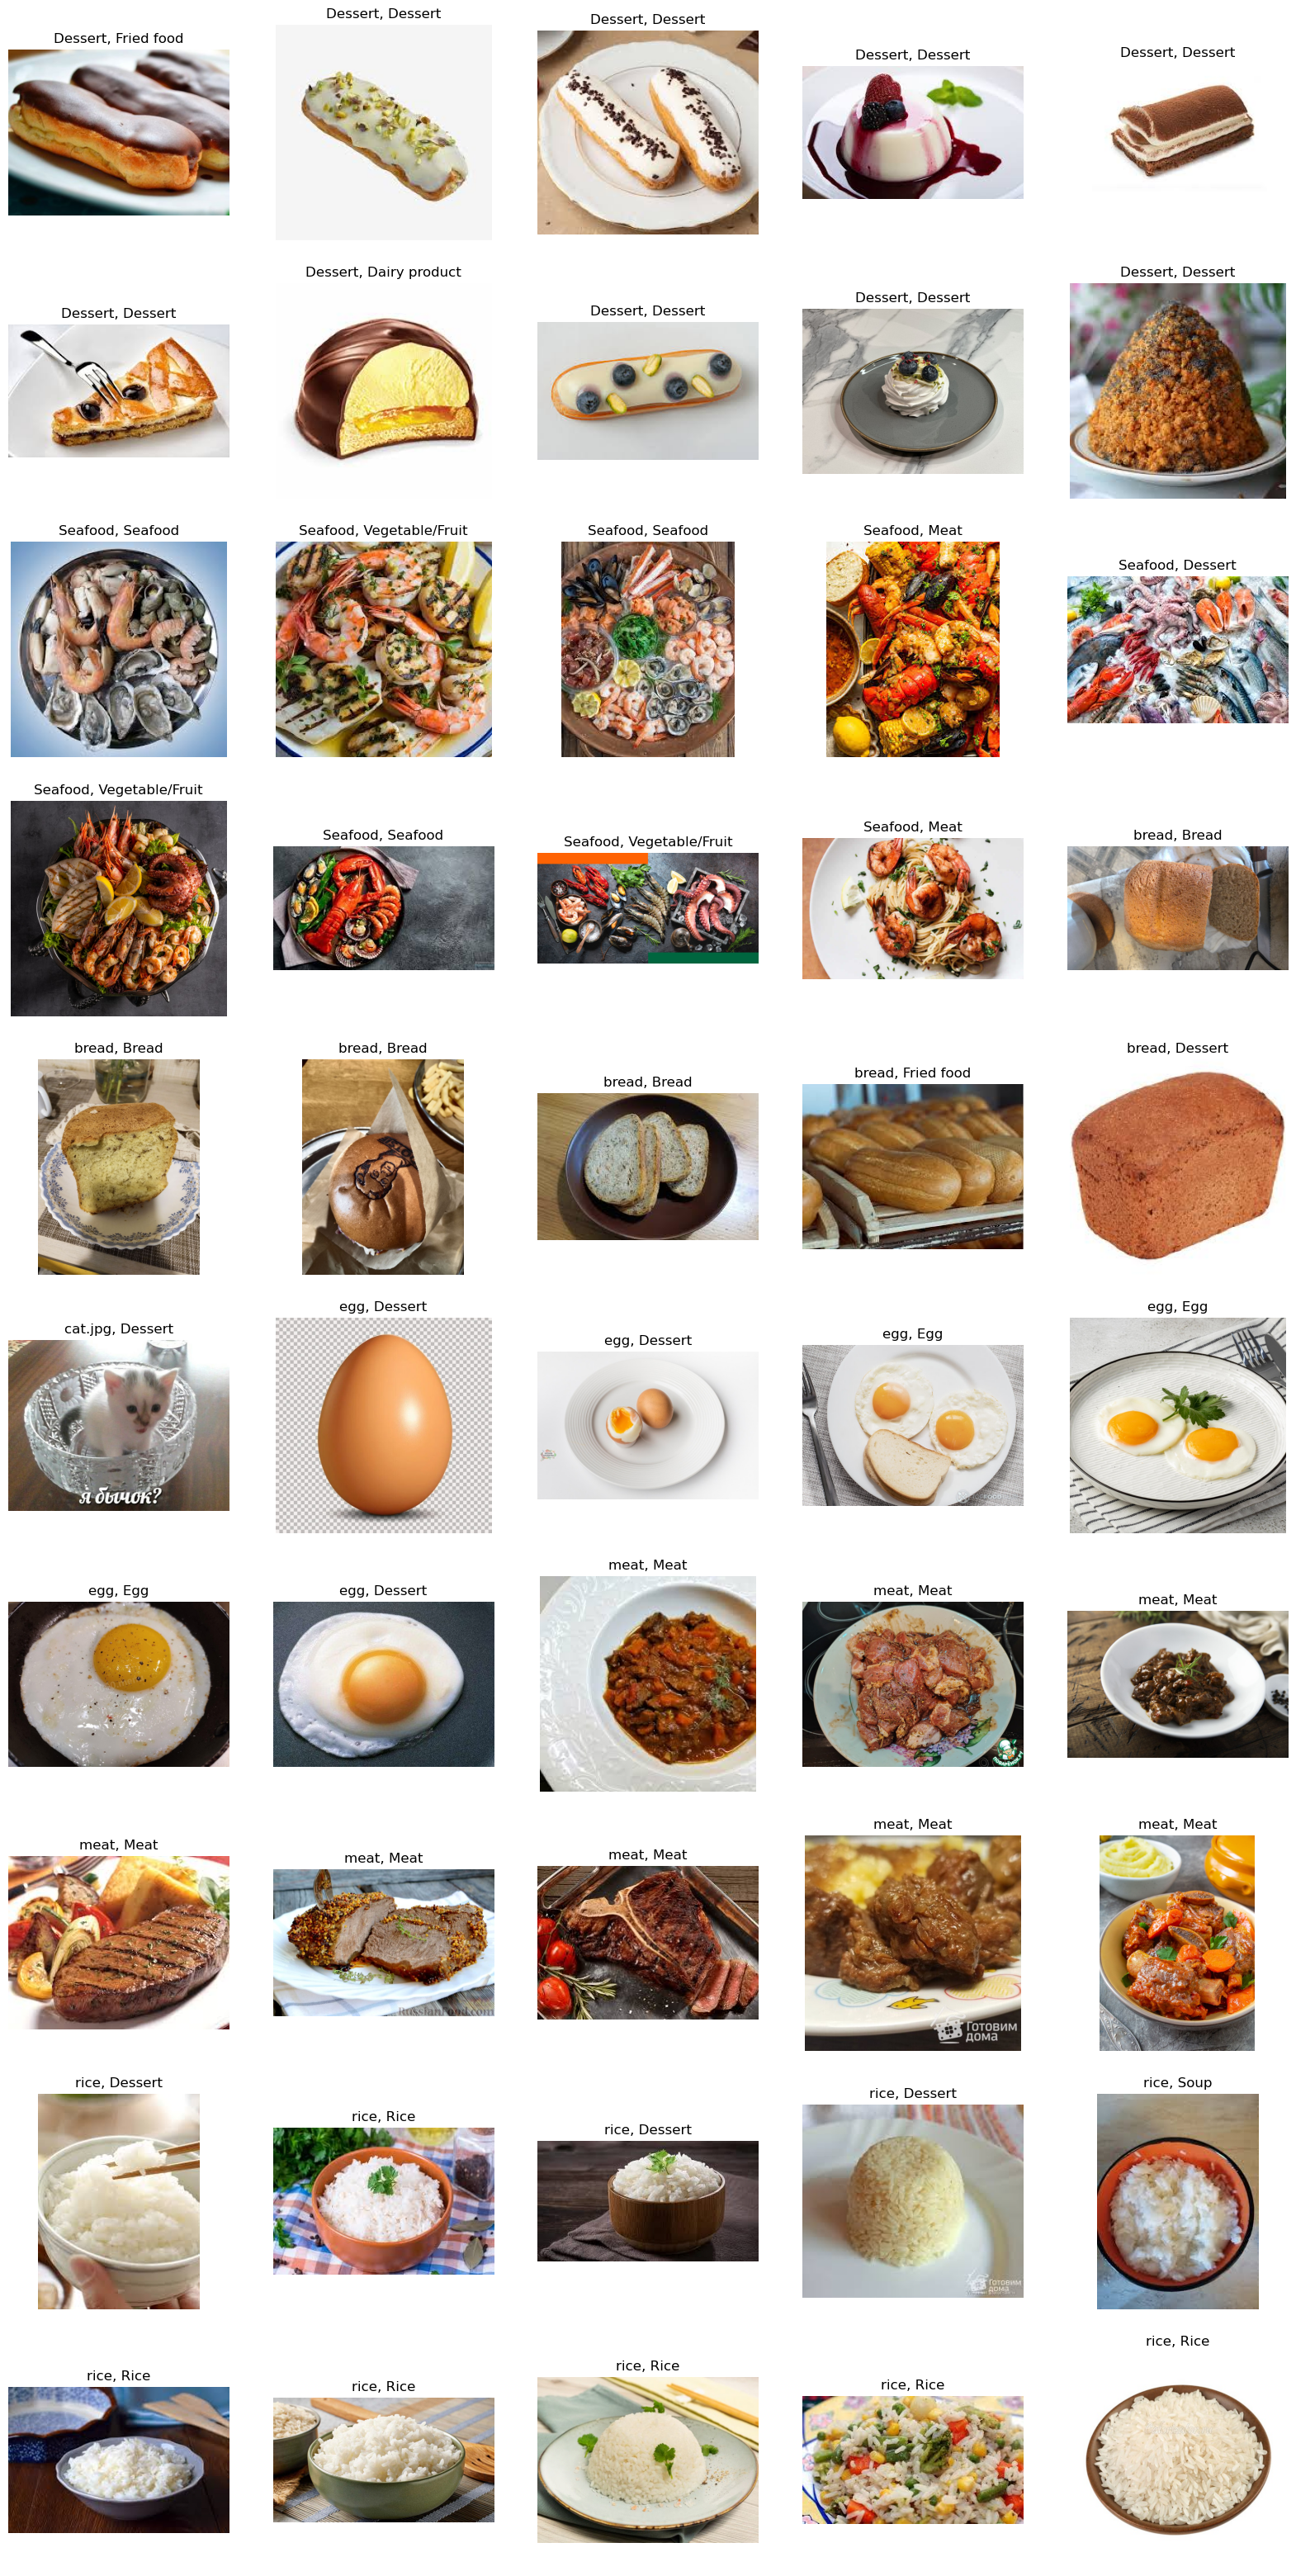

In [19]:
def sefl_validate(val_path="./self_objects/"):
    all_photos = [i for i in os.listdir(val_path) if i.endswith(".jpg")]
    print(len(all_photos))
    cols = 5 
    rows = len(all_photos) // cols + int(len(all_photos) % cols > 0) 
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 40))
    row = 0
    col = 0
    for i in all_photos:
        img = val_test_transform(Image.open(os.path.join(val_path, i)))
        out = model(img.resize(1, 3, 224, 224).to(device))
        _, predicted = torch.max(out, 1)
        
        axes[row, col].imshow(Image.open(os.path.join(val_path, i)))
        axes[row, col].set_title(f'{i.split("_")[0]}, {class_names[predicted[0]]}')
        axes[row, col].axis('off')
        col = (col + 1) % cols
        row += (col % cols == 0)
        
sefl_validate()